# Replication of plot from actual research article.

With the tutorial you will reproduce two curves from figure 3 panel A of "A novel automated behavioral test battery assessing
cognitive rigidity in two genetic mouse models of autism" (A. Puścian et al.) available at http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4010752/.

## Setting up the environment
At the beginning download and load into the memory the original data performing validity check, as well as the experiment timeline config file (see tutorials on basic and advanced topics for details). To save both storage and data transfer time the data has been preprocessed to filter out data unrelated to the research (diagnostic information and data from other research run simultaneously in the system).

In [1]:
import glob
import pymice as pm

pm.getTutorialData(quiet=True)

files = glob.glob('C57_AB/*.zip')
loaders = [pm.Loader(filename, getLog=True) for filename in files]
mm = pm.Merger(*loaders, getLog=True)

experimentTimeline = pm.ExperimentTimeline('C57_AB/timeline.ini')

PyMICE library v. 0.2.2
(NeuroLex.org ID: nlx_158570)

This is a bleeding edge version of the library. It might meet your
expectations, however it might also go to your fridge, drink all the
beer it can find there and then eat your cat. Be warned.



Check if there was no problems (indicated in log) in the period of our interest.

In [2]:
from datetime import timedelta
start, end = experimentTimeline.getTime(['Place Pref 1 dark', 'Place Pref 3 light'])
start -= timedelta(1) # one day

dataValidator = pm.DataValidator(pm.PresenceLogAnalyzer())
validatorReport = dataValidator(mm)

presenceTester = pm.TestMiceData('Presence')
   
if presenceTester(validatorReport, (start, end)):
    print "presences ok"

presences ok


In the 'Place Preference' phases a visit is rewarded if it is performed to a corner marked for the visiting animal as "correct" ("CornerCondition" attribute of the visit is positive then).

In [3]:
def isToCorrectCorner(visit):
    return visit.CornerCondition > 0

You need to know for every mouse, which corner was marked as "correct" during Place Preference phase. Since exactly one corner was marked as "correct" for an animal, it is enough to find first visit to such corner.

In [4]:
correctCorner = {}
t1, t2 = experimentTimeline.getTime('Place Pref 1 dark')
for mouse in mm.getMice():
    correctCorner[mouse] = None
    for visit in mm.getVisits(mice=mouse, start=t1, end=t2):
        if isToCorrectCorner(visit):
            correctCorner[mouse] = int(visit.Corner)
            break

print "Animal name\tCorrect corner"
for mouse, corner in correctCorner.items():
    print "%s:\t%s" % (mouse, corner)

Animal name	Correct corner
C57 B 10:	4
C57 B 11:	4
C57 B 12:	4
C57 B 6:	2
C57 B 7:	None
C57 B 4:	2
C57 B 5:	2
C57 B 2:	1
C57 A 8:	3
C57 B 1:	1
C57 A 5:	2
C57 A 4:	2
C57 A 7:	3
C57 A 6:	2
C57 A 1:	1
C57 A 3:	1
C57 A 2:	1
C57 A 11:	4
C57 A 10:	4
C57 B 8:	None
C57 B 9:	3
C57 A 9:	3
C57 B 3:	1


Now we are going to calculate for every mouse a fraction of visits to the rewarded corner in 12 hour timebins. For that purpose use the numpy library.

In [5]:
import numpy as np
import matplotlib.dates as mpd

binWidth = 0.5 # in days
startNum, endNum = mpd.date2num((start, end))
nBins = np.ceil((endNum - startNum) / binWidth)
bins = np.linspace(startNum, startNum + nBins * binWidth, int(nBins) + 1)

rewardedVisitsFractions = {}
for mouse, corner in correctCorner.items():
    visits = mm.getVisits(mice=mouse, start=start, end=end)
    startTimes = mpd.date2num([visit.Start for visit in visits])
    rewardedStartTimes = mpd.date2num([visit.Start for visit in visits if int(visit.Corner) == corner])
    
    visitHistogram, _ = np.histogram(startTimes, bins=bins)
    rewardedVisitHistogram, _ = np.histogram(rewardedStartTimes, bins=bins)
    rewardedFractionHistogram = rewardedVisitHistogram / visitHistogram.astype(float)
    rewardedVisitsFractions[mouse] = rewardedFractionHistogram

/home/jkowalski/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


For every defined group of mice we create an array of fractions (with mice in rows and time bins in columns) with invalid values masked.

In [6]:
rewardedVisitsArray = {}
for groupName in mm.getGroup():
    group = mm.getGroup(groupName)
    mice = map(unicode, group.Animals)
    miceFractions = [rewardedVisitsFractions[mouse] for mouse in mice]
    rewardedVisitsArray[groupName] = np.ma.masked_invalid(miceFractions)

And now we are plotting the results. Yes, WE DO KNOW that we should use 95% CI for error bars.

%matplotlib magic command is for purpose of the ipython notebook only.

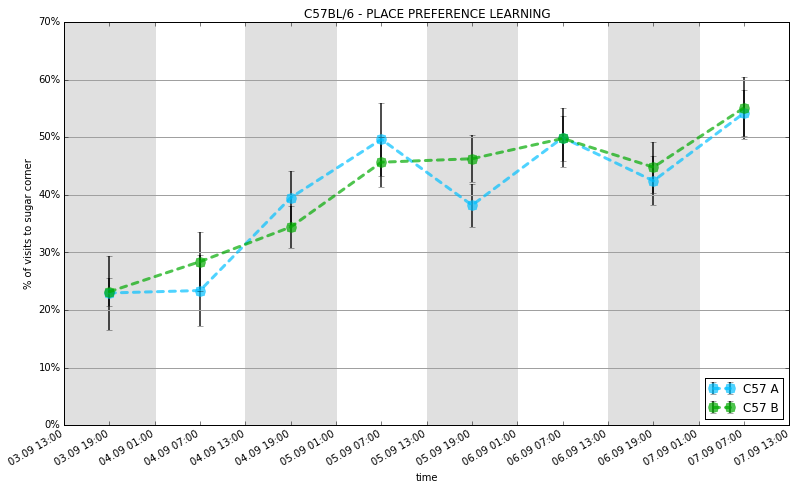

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import pytz

tzone = pytz.timezone('CET')

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim(0, 70)
ax.set_xlim(startNum, endNum)
ax.set_title('C57BL/6 - PLACE PREFERENCE LEARNING')
ax.set_ylabel('% of visits to sugar corner')
ax.set_xlabel('time')
hours=[1, 7, 13, 19]
ax.xaxis.set_major_locator(mpd.HourLocator(np.array(hours),tz=tzone))
ax.xaxis.set_major_formatter(mpd.DateFormatter('%d.%m %H:%M', tz=tzone))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.0f%%"))

for phase in experimentTimeline.sections():
  if phase.endswith('dark'):
    t1, t2 = experimentTimeline.getTime(phase)
    plt.axvspan(mpd.date2num(t1), mpd.date2num(t2), color='#E0E0E0')
    
for i in range(10, 70, 10):
  ax.axhline(i, color='#A0A0A0', lw=1)

for groupName, color in [('C57 A', '#00c0ff'),
                         ('C57 B', '#00aa00'),]:
  data = rewardedVisitsArray[groupName]
  mean = data.mean(axis=0)
  sem = data.std(axis=0) / np.sqrt(np.logical_not(data.mask).sum(axis=0))
  x = bins[:-1] + binWidth / 2
  y = mean * 100
  errorBar = sem * 100
  ax.errorbar(x, y, yerr=errorBar,
              linewidth=3, elinewidth=2,
              marker='o', markeredgecolor=color,
              markersize=10,
              ecolor="black",
              color=color, linestyle='--',
              dash_capstyle='round',
              label=groupName,
              alpha=0.69)

ax.legend(loc='lower right')

ax.autoscale_view()
fig.autofmt_xdate()
#plt.draw()

plt.show()